# Genetic Programming

**Context**

This walkthrough will demonstrate genetic programming (GP) in DEAP. To do that we will address the 'odd parity' problem.

Parity is one of the classical GP problems. The input is an array of Boolean values. The solution should output a 'parity bit' of 1 if there are an even number of values, and a 0 otherwise. Usually 6 Boolean inputs are used (Parity-6), and the goal is to match the good parity bit value for each of the possible entries.



In [ ]:
import operator
import random
import pygraphviz as pgv
import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# Training data generation

First we initialize the parity problem input and output (target) matrices

In [ ]:
PARITY_FANIN_M = 6
PARITY_SIZE_M = 2**PARITY_FANIN_M

inputs = [None] * PARITY_SIZE_M
outputs = [None] * PARITY_SIZE_M

In [ ]:
for i in range(PARITY_SIZE_M):
    inputs[i] = [None] * PARITY_FANIN_M
    value = i
    dividor = PARITY_SIZE_M
    parity = 1
    for j in range(PARITY_FANIN_M):
        dividor /= 2
        if value >= dividor:
            inputs[i][j] = 1
            parity = int(not parity)
            value -= dividor
        else:
            inputs[i][j] = 0
    outputs[i] = parity

Let's have a look at the training data that have been generated

In [ ]:
len(inputs)

64

In [ ]:
for i, o in zip(inputs,outputs):
    print(i,o)

[0, 0, 0, 0, 0, 0] 1
[0, 0, 0, 0, 0, 1] 0
[0, 0, 0, 0, 1, 0] 0
[0, 0, 0, 0, 1, 1] 1
[0, 0, 0, 1, 0, 0] 0
[0, 0, 0, 1, 0, 1] 1
[0, 0, 0, 1, 1, 0] 1
[0, 0, 0, 1, 1, 1] 0
[0, 0, 1, 0, 0, 0] 0
[0, 0, 1, 0, 0, 1] 1
[0, 0, 1, 0, 1, 0] 1
[0, 0, 1, 0, 1, 1] 0
[0, 0, 1, 1, 0, 0] 1
[0, 0, 1, 1, 0, 1] 0
[0, 0, 1, 1, 1, 0] 0
[0, 0, 1, 1, 1, 1] 1
[0, 1, 0, 0, 0, 0] 0
[0, 1, 0, 0, 0, 1] 1
[0, 1, 0, 0, 1, 0] 1
[0, 1, 0, 0, 1, 1] 0
[0, 1, 0, 1, 0, 0] 1
[0, 1, 0, 1, 0, 1] 0
[0, 1, 0, 1, 1, 0] 0
[0, 1, 0, 1, 1, 1] 1
[0, 1, 1, 0, 0, 0] 1
[0, 1, 1, 0, 0, 1] 0
[0, 1, 1, 0, 1, 0] 0
[0, 1, 1, 0, 1, 1] 1
[0, 1, 1, 1, 0, 0] 0
[0, 1, 1, 1, 0, 1] 1
[0, 1, 1, 1, 1, 0] 1
[0, 1, 1, 1, 1, 1] 0
[1, 0, 0, 0, 0, 0] 0
[1, 0, 0, 0, 0, 1] 1
[1, 0, 0, 0, 1, 0] 1
[1, 0, 0, 0, 1, 1] 0
[1, 0, 0, 1, 0, 0] 1
[1, 0, 0, 1, 0, 1] 0
[1, 0, 0, 1, 1, 0] 0
[1, 0, 0, 1, 1, 1] 1
[1, 0, 1, 0, 0, 0] 1
[1, 0, 1, 0, 0, 1] 0
[1, 0, 1, 0, 1, 0] 0
[1, 0, 1, 0, 1, 1] 1
[1, 0, 1, 1, 0, 0] 0
[1, 0, 1, 1, 0, 1] 1
[1, 0, 1, 1, 1, 0] 1
[1, 0, 1, 1, 

# Setting up the algorithm

Our individual will be a function to which we will pass PARITY_FANIN_M values (here 6). As such, you need to define a primitive set that takes in that number of values. You would increase this if you wanted to pass more values, and have it at zero if your individual does not receive any arguments when it is executed.

In [ ]:
#pset = gp.PrimitiveSet("MAIN", 0)
pset = gp.PrimitiveSet("MAIN", PARITY_FANIN_M, "IN")

By default input arguments are termed ARG0, ARG2 ... ARGi. We're fine with that here, but let's look at how to name the first argument ARG0 to x.

In [ ]:
#pset.renameArguments(ARG0='x')

# Now let's add some functions

We now register our functions and terminals. We would normally not know the function in advance, and might want to start with a limited set and then expand if needed.

In [ ]:
pset.addPrimitive(operator.and_, 2)
pset.addPrimitive(operator.or_, 2)
pset.addPrimitive(operator.xor, 2)
pset.addPrimitive(operator.not_, 1)
pset.addTerminal(1)
pset.addTerminal(0)

It's possible to use other functions, such as math ones, but we're limited to logic functions here.

In [ ]:
#pset.addPrimitive(operator.add, 2)
#pset.addPrimitive(operator.sub, 2)
#pset.addPrimitive(operator.mul, 2)
#pset.addPrimitive(protectedDiv, 2)
#pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(math.sin, 1)
#pset.addPrimitive(math.cos, 1)

You can also add an **ephemeral Constant**. The value of the constant is randomly initialised and then kept constant for a particular individual tree, but will differ from one Tree to another. Again, we do not need that here.

In [ ]:
#pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

Note that we have used lambda to create an anonymous function on the fly. This is so that we can define the arguments to randint to constrain it between -1 and 1.

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

The only real decision that you need to make when defining populations in the toolbox is what type of initialization you want to use. Individuals will always be of type toolbox.expr.

In [ ]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)

In [ ]:
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

You might consider adding some limits on the height of any generated branch.

In [ ]:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=4))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))

## Evaluation function

Provided below is the evaluation function that you should use.

In [ ]:
def evalParity(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*in_) == out for in_, out in zip(inputs, outputs)),

In [ ]:
toolbox.register("evaluate", evalParity)

## Register some stats

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

## Main algorithm

Before, you've always seen the full algorithm coded out. You can do the same here, but for brevity in this walkthrough I have used eaSimple.

In [ ]:
pop = toolbox.population(n=500)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=150, stats=mstats,
                                   halloffame=hof, verbose=True)

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg   	gen	max	min	nevals	std    	avg   	gen	max	min	nevals	std    
0  	500   	32.008	0  	34 	26 	500   	0.40489	17.832	0  	59 	4  	500   	10.8368
1  	289   	32.06 	1  	34 	28 	289   	0.385227	17.414	1  	59 	2  	289   	12.0522
2  	271   	32.114	2  	34 	28 	271   	0.470111	17.392	2  	59 	1  	271   	12.758 
3  	270   	32.262	3  	40 	32 	270   	0.693798	18.38 	3  	59 	1  	270   	13.7782
4  	281   	32.508	4  	40 	32 	281   	0.849668	22.25 	4  	59 	1  	281   	16.3569
5  	246   	32.964	5  	40 	29 	246   	1.09485 	29.912	5  	59 	1  	246   	17.1308
6  	282   	33.634	6  	40 	30 	282   	1.24902 	37.854	6  	59 	1  	282   	13.799 
7  	285   	34.152	7  	40 	30 	285   	1.664   	40.818	7  	55 	4  	285   	11.1427
8  	264   	34.77 	8  	40 	24 	264   	2.25058 	38.942	8  	51 	1  	264

100	274   	47.552	100	48 	32 	274   	2.59062 	25.4  	100	33 	6  	274   	2.43393
101	267   	47.28 	101	48 	16 	267   	3.59466 	25.268	101	33 	1  	267   	2.92783
102	251   	47.584	102	48 	32 	251   	2.40394 	25.51 	102	31 	1  	251   	2.11043
103	265   	47.408	103	48 	32 	265   	2.95593 	25.434	103	31 	1  	265   	3.38078
104	278   	47.636	104	48 	24 	278   	2.41402 	25.8  	104	35 	1  	278   	2.63363
105	277   	47.492	105	48 	24 	277   	2.85201 	25.596	105	34 	1  	277   	3.22688
106	260   	47.456	106	48 	32 	260   	2.85518 	25.718	106	34 	3  	260   	2.45489
107	250   	47.544	107	48 	32 	250   	2.59539 	25.556	107	34 	1  	250   	2.53355
108	287   	47.656	108	48 	32 	287   	2.24358 	25.65 	108	34 	12 	287   	2.21619
109	284   	47.404	109	48 	24 	284   	2.98342 	25.596	109	34 	1  	284   	2.40516
110	292   	47.38 	110	48 	32 	292   	2.98389 	25.586	110	34 	6  	292   	2.38717
111	266   	47.512	111	48 	16 	266   	2.91511 	25.658	111	34 	1  	266   	2.44807
112	253   	47.552	112	48 	16 	253   	3.0

## Basic plots

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = log.chapters['fitness'].select("gen")
_min = log.chapters['fitness'].select("min")
_max = log.chapters['fitness'].select("max")
avgs = log.chapters['fitness'].select("avg")
stds = log.chapters['fitness'].select("std")

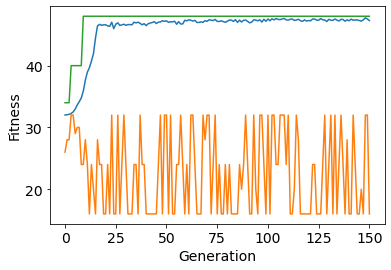

In [ ]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

line2 = ax1.plot(gen, _min)
line3 = ax1.plot(gen, _max)

Sometimes you might not be able to show the min and max on the same figure because of the scales.

Question: Why do you think the minimum is always so low?

## Let's examine our best individual

In [ ]:
indv = tools.selBest(pop, 1)[0]
print(indv)

and_(not_(xor(xor(IN2, xor(IN1, 0)), IN4)), xor(not_(or_(IN5, or_(1, not_(or_(IN4, and_(or_(IN0, 0), or_(1, IN0))))))), xor(IN5, xor(IN0, not_(IN3)))))


In [ ]:
nodes, edges, labels = gp.graph(indv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

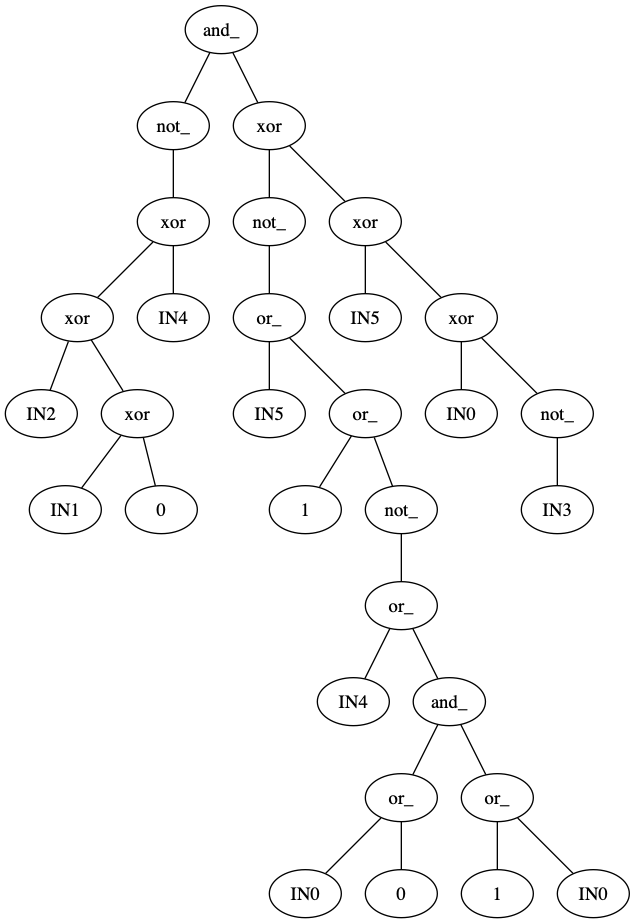

In [ ]:
from IPython.display import Image

treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

In [ ]:
toolbox.evaluate(indv)

(48,)